# Implied Volatility

Let's look at some real data to see how the Black-Scholes model can be calibrated. First get some option price data from Yahoo finance web API. We select Apple stock price options as they are traded in high volumes giving them small bid/ask spreads.

In [1]:
# import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy

# Define the ticker symbol and the expiration date
ticker_symbol = 'AAPL'  # Example: Apple
expiration_date = '2024-09-20'

# Fetch the option chain
option_chain = yf.Ticker(ticker_symbol).option_chain(expiration_date)

# Access call and put options data
calls = option_chain.calls
puts = option_chain.puts

print(calls.head())

        contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  AAPL240920C00005000 2024-02-16 14:51:42+00:00     5.0     178.58  176.30   
1  AAPL240920C00010000 2024-01-31 15:32:49+00:00    10.0     175.02  171.40   
2  AAPL240920C00015000 2024-02-23 14:32:03+00:00    15.0     169.94  166.90   
3  AAPL240920C00020000 2024-02-23 16:07:45+00:00    20.0     163.23  161.75   
4  AAPL240920C00025000 2024-01-25 18:43:01+00:00    25.0     169.75  156.60   

      ask   change  percentChange  volume  openInterest  impliedVolatility  \
0  178.85  0.00000       0.000000     1.0             7           1.851563   
1  173.95  0.00000       0.000000    17.0            18           1.654299   
2  168.55 -9.25000      -5.162118     1.0             0           1.458987   
3  164.05 -2.62001      -1.579747     1.0             4           1.400394   
4  159.20  0.00000       0.000000     2.0             2           1.253910   

   inTheMoney contractSize currency  
0        True     

The data is quite detailed and gives a lot of information. At the moment, we are just interested in the strike price, and the current bid and ask prices for the options.

In [2]:

# get market price data
call_market_prices = calls[['strike','bid', 'ask']]
put_market_prices = puts[['strike','bid', 'ask']]


Now add in a column for the mid prices as our model of the market price.

In [3]:

# add the mid prices
for index in call_market_prices.index:
    call_market_prices.loc[index,'midPrice'] = 0.5*call_market_prices.loc[index,'bid'] + 0.5*call_market_prices.loc[index,'ask']
for index in put_market_prices.index:
    put_market_prices.loc[index,'midPrice'] = 0.5*put_market_prices.loc[index,'bid'] + 0.5*put_market_prices.loc[index,'ask']
print(call_market_prices.head())

   strike     bid     ask  midPrice
0     5.0  176.30  178.85   177.575
1    10.0  171.40  173.95   172.675
2    15.0  166.90  168.55   167.725
3    20.0  161.75  164.05   162.900
4    25.0  156.60  159.20   157.900


/tmp/ipykernel_431/1956883510.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_market_prices.loc[index,'midPrice'] = 0.5*call_market_prices.loc[index,'bid'] + 0.5*call_market_prices.loc[index,'ask']
/tmp/ipykernel_431/1956883510.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  put_market_prices.loc[index,'midPrice'] = 0.5*put_market_prices.loc[index,'bid'] + 0.5*put_market_prices.loc[index,'ask']


Next we need to get some of the variables in our model. We need the value of the current stock price and the time to expiry, quoted as a fraction of a year.

In [6]:

# Display the option data (example)
S0 = option_chain.underlying['regularMarketPrice']

# Get the fraction of a year between current date and the expiration date
dateCurrent = datetime.date(2024,2,27)
dateExpiration =  datetime.date(2024,9,20)
T = (dateExpiration-dateCurrent).days / 365.

print(" Stock Price:-",S0,"Time to expiry:-",T)

 Stock Price:- 182.52 Time to expiry:- 0.5643835616438356


We also need a value for the risk free interest rate, this could be observed from another market (such as the bond market), or could be *implied* from the data by using a relationship such as the put call parity. Let's just choose a value of $r=0.03$.

In [53]:

r0=0.03


To check how good this is, let's plot the discounted payoff versus the option prices. First create the discounted payoff formula:
$$
\hat C = \max(S - Xe^{-rT},0)
$$
$$
\hat P = \max(Xe^{-rT} - S,0)
$$

In [54]:

# 
for index in call_market_prices.index:
    call_market_prices.loc[index,'exercisePrice'] = max(S0 - call_market_prices.loc[index,'strike']*np.exp(-r0*T),0.0)
for index in put_market_prices.index:
    put_market_prices.loc[index,'exercisePrice'] = max(put_market_prices.loc[index,'strike']*np.exp(-r0*T) - S0,0.0)

And now plot them out against the market prices

Text(0, 0.5, 'Option Prices')

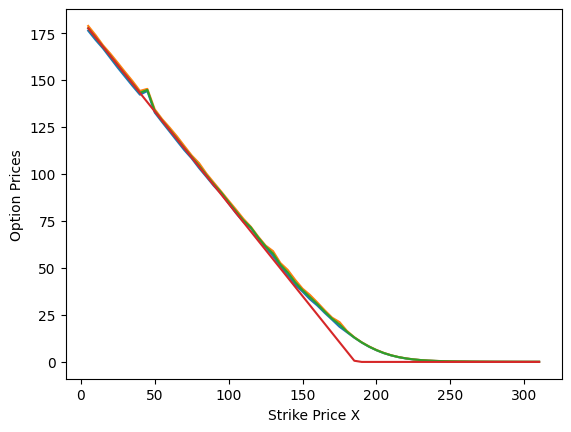

In [55]:

plt.plot(call_market_prices['strike'],call_market_prices['bid'])
plt.plot(call_market_prices['strike'],call_market_prices['ask'])
plt.plot(call_market_prices['strike'],call_market_prices['midPrice'])
plt.plot(call_market_prices['strike'],call_market_prices['exercisePrice'])
plt.xlabel("Strike Price X")
plt.ylabel("Option Prices")

Text(0, 0.5, 'Option Prices')

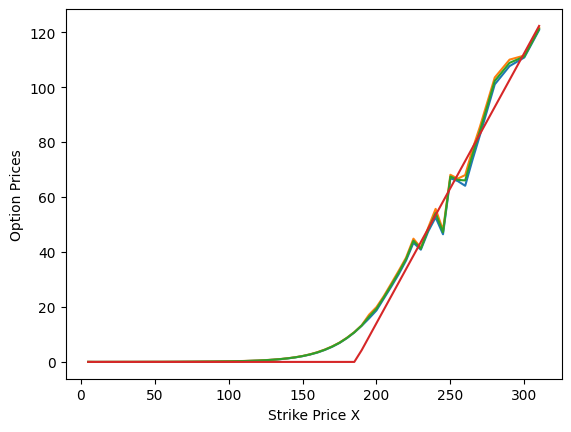

In [56]:

plt.plot(put_market_prices['strike'],put_market_prices['bid'])
plt.plot(put_market_prices['strike'],put_market_prices['ask'])
plt.plot(put_market_prices['strike'],put_market_prices['midPrice'])
plt.plot(put_market_prices['strike'],put_market_prices['exercisePrice'])
plt.xlabel("Strike Price X")
plt.ylabel("Option Prices")

Now define the Black-Scholes formula in code, we have the formula
$$
C(S,t) = S N(d_1) - Xe^{-r(T-t)}N(d_2)
$$
$$
d_1 = \frac{ \ln(S/X)+(r+\frac12\sigma^2)(T-t)}{\sigma\sqrt{T-t}}
$$
$$
d_2 = \frac{ \ln(S/X)+(r-\frac12\sigma^2)(T-t)}{\sigma\sqrt{T-t}}
$$


In [57]:
def BlackScholes(S,T,X,r,sigma):
    d1=(np.log(S/X) + (r+0.5*sigma*sigma)*T)/(sigma*np.sqrt(T))
    d2=(np.log(S/X) + (r-0.5*sigma*sigma)*T)/(sigma*np.sqrt(T))
    return S*scipy.special.ndtr(d1) - X*np.exp(-r*T)*scipy.special.ndtr(d2) 

So given the Black-Scholes model, we might try guessing a value of the sigma parameter and then test it out on the call option prices. Here we just set $\sigma=0.2$ and calculate the corresponding option prices.

In [58]:
sigma=0.2
for index in call_market_prices.index:
    X = call_market_prices.loc[index,'strike'] 
    call_market_prices.loc[index,'bsTest'] = BlackScholes(S0,T,X,r0,sigma)

Text(0, 0.5, 'Option Prices')

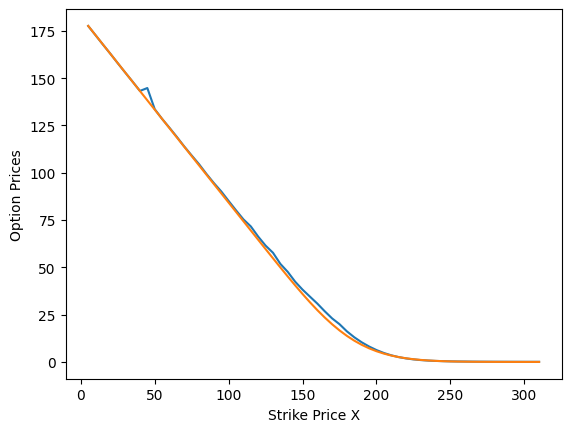

In [59]:
plt.plot(call_market_prices['strike'],call_market_prices['midPrice'])
plt.plot(call_market_prices['strike'],call_market_prices['bsTest'])
plt.xlabel("Strike Price X")
plt.ylabel("Option Prices")

We notice that the blue line (the real data) is quite a lot higher than the orange line (the model data) in the region $X\in[150,200]$. Note that there is no single value of $\sigma$ that can map the orange line on top of the blue line.

Now let us denote the model error by the difference between the two lines. If $C_0^i$ is the market price of the option with strike price $X^i$, then the error 
$$
\text{Model error}(\sigma) = ( S_0 N(d_1(S_0,T,X^i,r,\sigma)) - X^i e^{-rT} N(d_2(S_0,T,X^i,r,\sigma))) - C^i_0
$$
As stated above, we can't find a single value of $\sigma$ that will set the model error to zero for all the different values of the strike price.

In [60]:
for index in call_market_prices.index:
    X = call_market_prices.loc[index,'strike'] 
    C0 = call_market_prices.loc[index,'midPrice'] 
    modelError = lambda ss:BlackScholes(S0,T,X,r0,ss) - C0
    print(modelError(0.2))

0.02894487225194098
0.012889744503837619
0.04683461675574563
-0.04422051099231794
0.03972436125962986
0.02366923351155492
-0.06738589423656549
-0.05844102198460632
-6.499496149732664
-0.24055127748076188
-0.00660640522883682
-0.22266153297687197
-0.2887166607218319
-0.15477178836756877
-0.34582691400008514
-0.6368820119695613
-0.4029368374122413
-0.5189896461996995
-1.010030808709459
-0.876017785212909
-0.8417961615233622
-0.9818949253465661
-2.170083561160169
-1.6785639562547061
-1.8267214465089765
-2.9294981797159636
-1.8706521992656775
-2.42634934662307
-1.9396057246334806
-2.2959941341521954
-2.975760121009472
-3.457146251998534
-3.2954150298666818
-3.101890800233292
-3.2973518175692753
-2.389273452277841
-1.7976850204605856
-1.3296748529541418
-0.9527946861313215
-0.6177393736349988
-0.3307072724485547
-0.1257997925168297
0.007274065075318248
0.07003031195858656
0.09152152402188563
0.07914659379429134
0.05902821770118738
0.021052424081043353
-0.00133090764410293
-0.016456433957083

Instead let's try to find a different value of $\bar \sigma^i$ for every strike price $X^i$, the so called *implied volatility*. In order to do that we just need to find $\bar \sigma^i$ such that 
$$
\text{Model error}(\bar \sigma^i) = 0
$$
This is a classic root find, so choosing some appropriate starting guessing for $\sigma$ we get the following picture:

(0.15, 0.5)

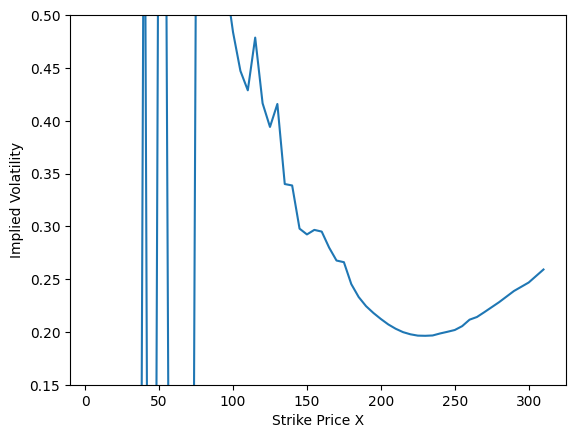

In [61]:
for index in call_market_prices.index:
    X = call_market_prices.loc[index,'strike'] 
    C0 = call_market_prices.loc[index,'midPrice'] 
    modelError = lambda ss:BlackScholes(S0,T,X,r0,ss) - C0
    result = scipy.optimize.root_scalar(modelError,x0=0.2,x1=0.5)
    if result.converged == True:
        call_market_prices.loc[index,'impliedVol']=result.root
    else:
        call_market_prices.loc[index,'impliedVol']=-1

plt.plot(call_market_prices['strike'],call_market_prices['impliedVol'])
plt.xlabel("Strike Price X")
plt.ylabel("Implied Volatility")
plt.ylim(0.15,0.5)

What we see here is the classic volatility smile, as volatility appears smallest when $S_0\approx X$, and then gets larger either side of those values. There are some assumptions I've made here to keep things simple (no dividends and no early exercise), and looking at the implied volatilities we get from yahoo, there is clearly something missing (most likely dividend yield).
 

(0.15, 0.5)

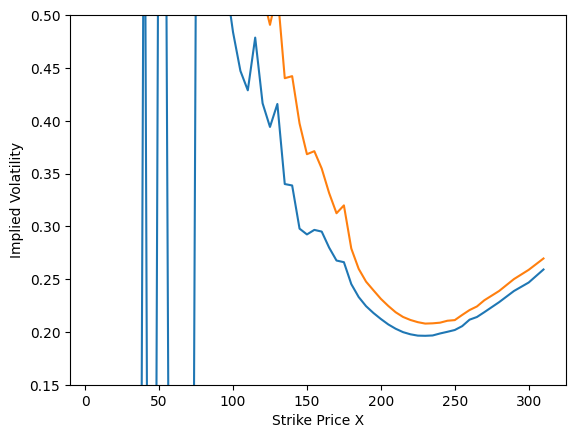

In [63]:
plt.plot(call_market_prices['strike'],call_market_prices['impliedVol'])
plt.plot(call_market_prices['strike'],calls['impliedVolatility'])
plt.xlabel("Strike Price X")
plt.ylabel("Implied Volatility")
plt.ylim(0.15,0.5)